# Multi-period OPF example

Re-create PyPower case from CSV files

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nygrid.run_nygrid import NYGrid
import pickle

In [2]:
# Set up directories
cwd = os.getcwd()
if 'dev' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

solar_data_dir = os.path.join(data_dir, 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

buildings_data_dir = os.path.join(data_dir, 'buildings')
print('Buildings data directory: {}'.format(buildings_data_dir))

Grid data directory: D:\EERL\OneMet\NYgrid-python\data\grid
Figure directory: D:\EERL\OneMet\NYgrid-python\figures
Results directory: D:\EERL\OneMet\NYgrid-python\results
Solar data directory: D:\EERL\OneMet\NYgrid-python\data\solar
Onshore wind data directory: D:\EERL\OneMet\NYgrid-python\data\onshore_wind
Offshore wind data directory: D:\EERL\OneMet\NYgrid-python\data\offshore_wind
Buildings data directory: D:\EERL\OneMet\NYgrid-python\data\buildings


## Read grid data

### Read generator profiles

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'


# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmax_profile.index.freq = 'H'

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmin_profile.index.freq = 'H'

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genramp30_profile.index.freq = 'H'

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost0_profile.index.freq = 'H'

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost1_profile.index.freq = 'H'


In [4]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read variable renewable energy (VRE) data

In [5]:
# Renewable generation time series
current_solar_gen = pd.read_csv(os.path.join(solar_data_dir, f'current_solar_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time').asfreq('H')
current_solar_gen.columns = current_solar_gen.columns.astype(int)

future_solar_gen = pd.read_csv(os.path.join(solar_data_dir, f'future_solar_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time').asfreq('H')
future_solar_gen.columns = future_solar_gen.columns.astype(int)

onshore_wind_gen = pd.read_csv(os.path.join(onshore_wind_data_dir, f'current_wind_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time').asfreq('H')
onshore_wind_gen.columns = onshore_wind_gen.columns.astype(int)

offshore_wind_gen = pd.read_csv(os.path.join(offshore_wind_data_dir, f'power_load_2018.csv'),
                                parse_dates=['timestamp'], index_col='timestamp')
offshore_wind_gen.index = offshore_wind_gen.index.tz_localize('US/Eastern', ambiguous='infer')
offshore_wind_gen.index.freq = 'H'

# Wind farm capacity info
capacity = [816, 1260, 924, 1230]
capacity_nyc, capacity_li = np.sum(capacity[:2]), np.sum(capacity[2:])

# Correct offshore wind generation
offshore_wind_gen['power_nyc'] = np.where(offshore_wind_gen['power_nyc'] > capacity_nyc, capacity_nyc, offshore_wind_gen['power_nyc'])
offshore_wind_gen['power_li'] = np.where(offshore_wind_gen['power_li'] > capacity_li, capacity_li, offshore_wind_gen['power_li'])

In [6]:
# Renewable allocation table
current_solar_2bus = pd.read_csv(os.path.join(solar_data_dir, f'solar_farms_2bus.csv'), index_col='zip_code')
future_solar_2bus = pd.read_csv(os.path.join(solar_data_dir, f'future_solar_farms_2bus.csv'), index_col=0)
onshore_wind_2bus = pd.read_csv(os.path.join(onshore_wind_data_dir, f'onshore_wind_2bus.csv'), index_col=0)

# Aggregate current solar generation
groupby_dict = current_solar_2bus['busIdx'].to_dict()
current_solar_gen_agg = current_solar_gen.groupby(groupby_dict, axis=1).sum()
current_solar_gen_agg = current_solar_gen_agg/1e3 # convert from kW to MW

# Aggregate future solar generation
groupby_dict = future_solar_2bus['busIdx'].to_dict()
future_solar_gen_agg = future_solar_gen.groupby(groupby_dict, axis=1).sum()
future_solar_gen_agg = future_solar_gen_agg/1e3 # convert from kW to MW

# Aggregate onshore wind generation
groupby_dict = onshore_wind_2bus['busIdx'].to_dict()
onshore_wind_gen_agg = onshore_wind_gen.groupby(groupby_dict, axis=1).sum()
onshore_wind_gen_agg = onshore_wind_gen_agg/1e3 # convert from kW to MW

# Aggregate offshore wind generation
offshore_wind_gen_agg = offshore_wind_gen[['power_nyc', 'power_li']].rename(
    columns={'power_nyc': 81, 'power_li': 82})

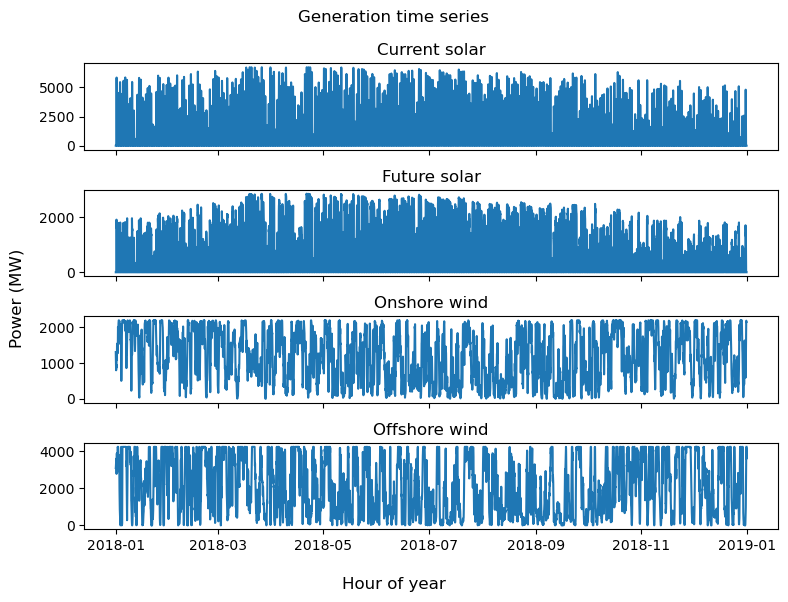

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(8, 6),
                        sharex='all')
axs[0].plot(current_solar_gen_agg.sum(axis=1), label='Current solar')
axs[1].plot(future_solar_gen_agg.sum(axis=1), label='Future solar')
axs[2].plot(onshore_wind_gen_agg.sum(axis=1), label='Onshore wind')
axs[3].plot(offshore_wind_gen_agg.sum(axis=1), label='Offshore wind')

titles = ['Current solar', 'Future solar', 'Onshore wind', 'Offshore wind']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
fig.suptitle('Generation time series')
fig.tight_layout()

In [8]:
# 18.08% of current solar generation is built before 2018 (base year)
# Scale down current solar generation by 18.08%
pct_current_solar_built = 0.1808
current_solar_gen_agg = current_solar_gen_agg * (1-pct_current_solar_built)

# 90.6% of onshore wind generation is built before 2018 (base year)
# Scale down onshore wind generation by 90.6%
pct_onshore_wind_built = 0.906
onshore_wind_gen_agg = onshore_wind_gen_agg * (1-pct_onshore_wind_built)

In [9]:
vre_profiles = {'CurSol': current_solar_gen_agg,
                'FutSol': future_solar_gen_agg,
                'OnWind': onshore_wind_gen_agg,
                'OffWind': offshore_wind_gen_agg}
vre_prop_list = list()
for key, profile in vre_profiles.items():
    vre_prop_a = pd.DataFrame(data={'VRE_BUS': profile.columns,
                                    'VRE_PMAX': profile.max(axis=0),
                                    'VRE_PMIN': 0,
                                    'VRE_TYPE': 'Solar',
                                    'VRE_NAME': [f'{key}_{col}' for col in profile.columns]})
    vre_prop_list.append(vre_prop_a)
    
# Combine gen_prop tables
vre_prop = pd.concat(vre_prop_list, ignore_index=True)
vre_prop

,VRE_BUS,VRE_PMAX,VRE_PMIN,VRE_TYPE,VRE_NAME
0,37,77.904033,0,Solar,CurSol_37
1,38,68.687396,0,Solar,CurSol_38
2,39,90.918845,0,Solar,CurSol_39
3,40,76.602936,0,Solar,CurSol_40
4,41,89.028742,0,Solar,CurSol_41
...,...,...,...,...,...
86,69,0.000000,0,Solar,OnWind_69
87,80,0.009400,0,Solar,OnWind_80
88,81,0.000000,0,Solar,OnWind_81
89,81,2076.000000,0,Solar,OffWind_81


In [10]:
# Combine genmax tables
genmax_profile_vre = pd.concat([current_solar_gen_agg, future_solar_gen_agg,
                                onshore_wind_gen_agg, offshore_wind_gen_agg], axis=1)
genmax_profile_vre.columns = vre_prop['VRE_NAME']
genmax_profile_vre.index = genmax_profile_vre.index.tz_convert('US/Eastern').tz_localize(None)
genmax_profile_vre

VRE_NAME,CurSol_37,CurSol_38,CurSol_39,CurSol_40,CurSol_41,CurSol_42,CurSol_43,CurSol_44,CurSol_45,CurSol_46,...,OnWind_58,OnWind_60,OnWind_62,OnWind_64,OnWind_65,OnWind_69,OnWind_80,OnWind_81,OffWind_81,OffWind_82
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051012,11.666778,14.066085,15.563729,0.210635,0.0,0.007795,0.0,1005.664992,2088.625000
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039893,9.747859,11.439783,10.980977,0.210908,0.0,0.005606,0.0,1116.157083,1994.529683
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023814,7.386271,10.941958,8.323365,0.203995,0.0,0.005741,0.0,1260.128017,1935.640300
2018-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005331,5.564034,8.778212,9.253707,0.148417,0.0,0.006201,0.0,1340.852150,1965.535867
2018-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000283,1.275872,7.919764,9.198507,0.083164,0.0,0.007014,0.0,1356.833000,2088.592100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.241800,23.583720,18.475700,0.310200,0.0,0.009379,0.0,2076.000000,1575.333583
2018-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.241800,23.586480,18.475700,0.310200,0.0,0.009389,0.0,2076.000000,2107.629567
2018-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.220258,23.586480,18.475700,0.310200,0.0,0.009400,0.0,1638.623567,2154.000000
2018-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.190100,23.586480,18.475700,0.310200,0.0,0.008107,0.0,1425.989483,2154.000000


### Update load profile for electrification

In [11]:
# Read county to bus allocation table
county_2bus = pd.read_csv(os.path.join(buildings_data_dir, 'county_centroids_2bus.csv'), 
                          index_col=0)
fips_list = ['G'+s[:2]+'0'+s[2:]+'0' for s in county_2bus['FIPS_CODE'].astype(str)]

# County-level load data
# Residential buildings current load (upgrade=0)
pickle_dir = os.path.join(buildings_data_dir, 'euss_processed', 'upgrade=0')
res_current_load = pd.DataFrame()

for ii in range(len(fips_list)):
    pickle_file = os.path.join(pickle_dir, f'{fips_list[0]}_elec_total.pkl')
    # Read pickle file
    with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
        county_load = pickle.load(f)
        county_load = county_load.rename(columns={'total': fips_list[ii]})
        res_current_load = pd.concat([res_current_load, county_load], axis=1)

# Residential buildings future load (upgrade=10)
pickle_dir = os.path.join(buildings_data_dir, 'euss_processed', 'upgrade=10')
res_elec_load = pd.DataFrame()

for ii in range(len(fips_list)):
    pickle_file = os.path.join(pickle_dir, f'{fips_list[0]}_elec_total.pkl')
    # Read pickle file
    with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
        county_load = pickle.load(f)
        county_load = county_load.rename(columns={'total': fips_list[ii]})
        res_elec_load = pd.concat([res_elec_load, county_load], axis=1)

# Changes in residential load
res_load_change = res_elec_load - res_current_load
res_load_change.index.name = 'Time'

# Aggregate building load to buses
groupby_dict = dict(zip(fips_list, county_2bus['busIdx']))
res_load_change_bus = res_load_change.groupby(groupby_dict, axis=1).sum()
res_load_change_bus = res_load_change_bus/1e3 # convert from kW to MW

# NOTE: Scale down residential load change by 50%
res_load_change_bus = res_load_change_bus*0.5

# Load profile with residential load change only
load_profile_elec = load_profile.add(res_load_change_bus, fill_value=0)
load_profile_elec

,37,38,39,40,41,42,43,45,46,49,...,Bus73,Bus74,Bus75,Bus76,Bus77,Bus78,Bus79,Bus80,Bus81,Bus82
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,162.026447,324.052893,324.052893,648.105786,648.105786,162.026447,324.052893,648.105786,162.026447,486.079340,...,256.94,400.9,128.47,128.47,513.88,695.9,1112.614286,1483.485714,3036.65,3036.65
2018-01-01 01:00:00,160.353200,320.706400,320.706400,641.412801,641.412801,160.353200,320.706400,641.412801,160.353200,481.059601,...,245.62,394.8,122.81,122.81,491.24,668.0,1064.100000,1418.800000,2952.85,2952.85
2018-01-01 02:00:00,195.409776,390.819551,390.819551,781.639103,781.639103,195.409776,390.819551,781.639103,195.409776,586.229327,...,238.40,390.1,119.20,119.20,476.80,644.2,1021.714286,1362.285714,2872.35,2872.35
2018-01-01 03:00:00,220.345275,440.690550,440.690550,881.381099,881.381099,220.345275,440.690550,881.381099,220.345275,661.035825,...,238.14,377.4,119.07,119.07,476.28,619.6,997.371429,1329.828571,2812.85,2812.85
2018-01-01 04:00:00,227.218406,454.436812,454.436812,908.873623,908.873623,227.218406,454.436812,908.873623,227.218406,681.655217,...,238.04,379.5,119.02,119.02,476.08,612.7,989.957143,1319.942857,2786.00,2786.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,20.966124,41.932249,41.932249,83.864498,83.864498,20.966124,41.932249,83.864498,20.966124,62.898373,...,244.00,370.6,122.00,122.00,488.00,745.1,1123.414286,1497.885714,2993.65,2993.65
2018-12-31 20:00:00,21.370120,42.740240,42.740240,85.480480,85.480480,21.370120,42.740240,85.480480,21.370120,64.110360,...,232.18,357.4,116.09,116.09,464.36,717.0,1071.728571,1428.971429,2890.85,2890.85
2018-12-31 21:00:00,21.691428,43.382856,43.382856,86.765711,86.765711,21.691428,43.382856,86.765711,21.691428,65.074284,...,221.32,331.1,110.66,110.66,442.64,686.4,1013.314286,1351.085714,2784.35,2784.35


### Read DC line and ESR property file

In [12]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename, index_col=0)
dcline_prop

,DC_F_BUS,DC_T_BUS,DC_BR_STATUS,DC_PF,DC_PT,DC_QF,DC_QT,DC_VF,DC_VT,DC_PMIN,DC_PMAX,DC_QMINF,DC_QMAXF,DC_QMINT,DC_QMAXT,LOSS0,LOSS1,FROM_ZONE,TO_ZONE
0,21,80,1,12.666667,0,0,0,1.01,1,-530,530,-100,100,-100,100,0,0,NE,K
1,124,79,1,660.000000,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,K
2,125,81,1,599.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
3,125,81,1,223.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
4,48,81,1,0.000000,0,0,0,1.01,1,-1250,1250,-100,100,-100,100,0,0,D,J
5,69,81,1,0.000000,0,0,0,1.01,1,-1300,1300,-100,100,-100,100,0,0,E,J


In [13]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename, index_col=0)
esr_prop

,ESR_NAME,ESR_BUS,ESR_STATUS,ESR_CRG_MAX,ESR_DIS_MAX,ESR_CRG_EFF,ESR_DIS_EFF,ESR_SOC_MIN,ESR_SOC_MAX,ESR_SOC_INI,ESR_SOC_TGT,ESR_CRG_COST,ESR_DIS_COST,ESR_ZONE
0,Gilboa 1 (IIFO - 1/1/2019),42,1,280.0,291.8,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
1,Gilboa 2,42,1,280.0,292.7,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
2,Gilboa 3,42,1,280.0,291.9,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
3,Gilboa 4,42,1,280.0,292.5,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
4,Lewiston PS,56,1,230.0,240.0,0.59,0.59,0,2880,1440,1440,0.005,0.005,A
5,North County Energy Storage,47,1,20.0,20.0,0.85,0.85,0,200,100,100,0.005,0.005,E
6,zzAgg_J_ES__1,82,1,2.0,2.0,0.85,0.85,0,8,4,4,0.005,0.005,J
7,zzAgg_K_FC__1,80,1,18.5,18.5,0.85,0.85,0,74,37,37,0.005,0.005,K
8,A_ESR_Standalone,56,1,300.0,300.0,0.85,0.85,0,1200,600,600,0.005,0.005,A
9,B_ESR_Standalone,53,1,180.0,180.0,0.85,0.85,0,720,360,360,0.005,0.005,B


## Multi-period OPF

### Without initial conditions

In [14]:
# Only run for one day
d = 7
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-08 00:00:00
End time: 2018-01-09 23:00:00


#### Without ESR

In [15]:
# Create NYGrid object
nygrid_sim_wo_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            vre_prop=None,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 315
Number of branches: 94
Number of time periods: 48
Number of variables: 65520
Number of constraints: 80250
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmprlip78m5.pyomo.lp
Reading time = 0.41 seconds
x1: 80250 rows, 65521 columns, 403182 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 80250 rows, 65521 columns and 403182 nonzeros
Model fingerprint: 0xa3aa2955
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 74182 rows and 50057 

In [16]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 2526.230846685644
s_if_max 24616.6112857727
s_if_min 609.591242063951
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [17]:
# Create NYGrid object
nygrid_sim_w_esr = NYGrid(grid_data_dir, 
                          start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                          end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=None,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 345
Number of branches: 94
Number of time periods: 48
Number of variables: 74160
Number of constraints: 94620
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpb3hk10_b.pyomo.lp
Reading time = 0.45 seconds
x1: 94620 rows, 74161 columns, 433242 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 94620 rows, 74161 columns and 433242 nonzeros
Model fingerprint: 0xe156aa9c
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 86910 rows and 54249 

In [18]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 18753.164624287125
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE

In [19]:
# Create NYGrid object
nygrid_sim_w_vre = NYGrid(grid_data_dir, 
                          start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                          end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                          dcline_prop=dcline_prop,
                          esr_prop=None,
                          vre_prop=vre_prop,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre.set_load_sch(load_profile)
nygrid_sim_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre.solve_dc_opf()

# Get results
results_0_w_vre = nygrid_sim_w_vre.get_results_dc_opf()

Number of buses: 57
Number of generators: 406
Number of branches: 94
Number of time periods: 48
Number of variables: 78624
Number of constraints: 97540
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp8rhhi17t.pyomo.lp
Reading time = 0.45 seconds
x1: 97540 rows, 78625 columns, 446316 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 97540 rows, 78625 columns and 446316 nonzeros
Model fingerprint: 0x4f0ec18c
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 91125 rows and 61472 

In [20]:
print("s_ramp_up", results_0_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre['s_load_shed'].sum())
print("s_if_max", results_0_w_vre['s_if_max'].sum())
print("s_if_min", results_0_w_vre['s_if_min'].sum())
print("s_br_max", results_0_w_vre['s_br_max'].sum())
print("s_br_min", results_0_w_vre['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 25020.30067423757
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE and ESR

In [21]:
# Create NYGrid object
nygrid_sim_w_vre_esr = NYGrid(grid_data_dir, 
                          start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                          end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=vre_prop,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre_esr.set_load_sch(load_profile)
nygrid_sim_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre_esr.solve_dc_opf()

# Get results
results_0_w_vre_esr = nygrid_sim_w_vre_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 436
Number of branches: 94
Number of time periods: 48
Number of variables: 87264
Number of constraints: 111910
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp3spasgn0.pyomo.lp
Reading time = 0.49 seconds
x1: 111910 rows, 87265 columns, 476376 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 111910 rows, 87265 columns and 476376 nonzeros
Model fingerprint: 0x0f45bf3c
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 103790 rows and 65

In [22]:
print("s_ramp_up", results_0_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_0_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_0_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_0_w_vre_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 15860.003673970326
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### Results

In [23]:
ii = 5
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.08349999999999984, 0.0, 0.0, 0.2, 0.0, 0.0, -0.2, -0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, -0.2, 0.2, 0.0, -0.2, -0.2, 0.0, 0.0, 0.089, 0.0, 0.0, 0.2, 0.0, 0.0, -0.2, -0.2, -0.2, -0.2, 0.0, 0.2, 0.0, 0.0, -0.2, -0.053287197231833776, -0.2, -0.2]
discharging [0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.08349999999999984, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.089, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.053287197231833776, 0.2, 0.2]
SOC [1.0, 1.0, 1.0, 0.7647058823529411, 0.5294117647058822, 0.5294117647058822, 0.5294117647058822, 0.5294117647058822, 0.4311764705882354, 0.4311764705882354, 0.43117

In [24]:
print(f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}, {results_0_w_vre["total_cost"].sum():.2f}, {results_0_w_vre_esr["total_cost"].sum():.2f}')
print(f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}, {results_0_w_vre["gen_cost"].sum():.2f}, {results_0_w_vre_esr["gen_cost"].sum():.2f}')
print(f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}, {results_0_w_vre["over_gen_penalty"].sum():.2f}, {results_0_w_vre_esr["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}, {results_0_w_vre["load_shed_penalty"].sum():.2f}, {results_0_w_vre_esr["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_vre["ramp_up_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_vre["ramp_down_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}, {results_0_w_vre["if_max_penalty"].sum():.2f}, {results_0_w_vre_esr["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}, {results_0_w_vre["if_min_penalty"].sum():.2f}, {results_0_w_vre_esr["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}, {results_0_w_vre["br_max_penalty"].sum():.2f}, {results_0_w_vre_esr["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}, {results_0_w_vre["br_min_penalty"].sum():.2f}, {results_0_w_vre_esr["br_min_penalty"].sum():.2f}')

Total cost: 456171987.63, 339984220.33, 381508345.35, 289068911.45
Gen cost: 153385345.42, 152452574.09, 131305338.61, 130468874.71
Over generation penalty: 0.00, 0.00, 0.00, 0.00
Load shed penalty: 50524616.93, 0.00, 0.00, 0.00
Ramp up penalty: 0.00, 0.00, 0.00, 0.00
Ramp down penalty: 0.00, 0.00, 0.00, 0.00
Interface max penalty: 246166112.86, 187531646.24, 250203006.74, 158600036.74
Interface min penalty: 6095912.42, 0.00, 0.00, 0.00
Branch max penalty: 0.00, 0.00, 0.00, 0.00
Branch min penalty: 0.00, 0.00, 0.00, 0.00


In [25]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_w_esr.grid_data['bus_prop'].set_index('BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [26]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

lmp_w_vre = results_0_w_vre['LMP']
lmp_w_vre.columns = bus_names

lmp_w_vre_esr = results_0_w_vre_esr['LMP']
lmp_w_vre_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_esr_zone = lmp_w_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_vre_zone = lmp_w_vre.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_vre_esr_zone = lmp_w_vre_esr.groupby(bus_zone_alloc, axis=1).mean()

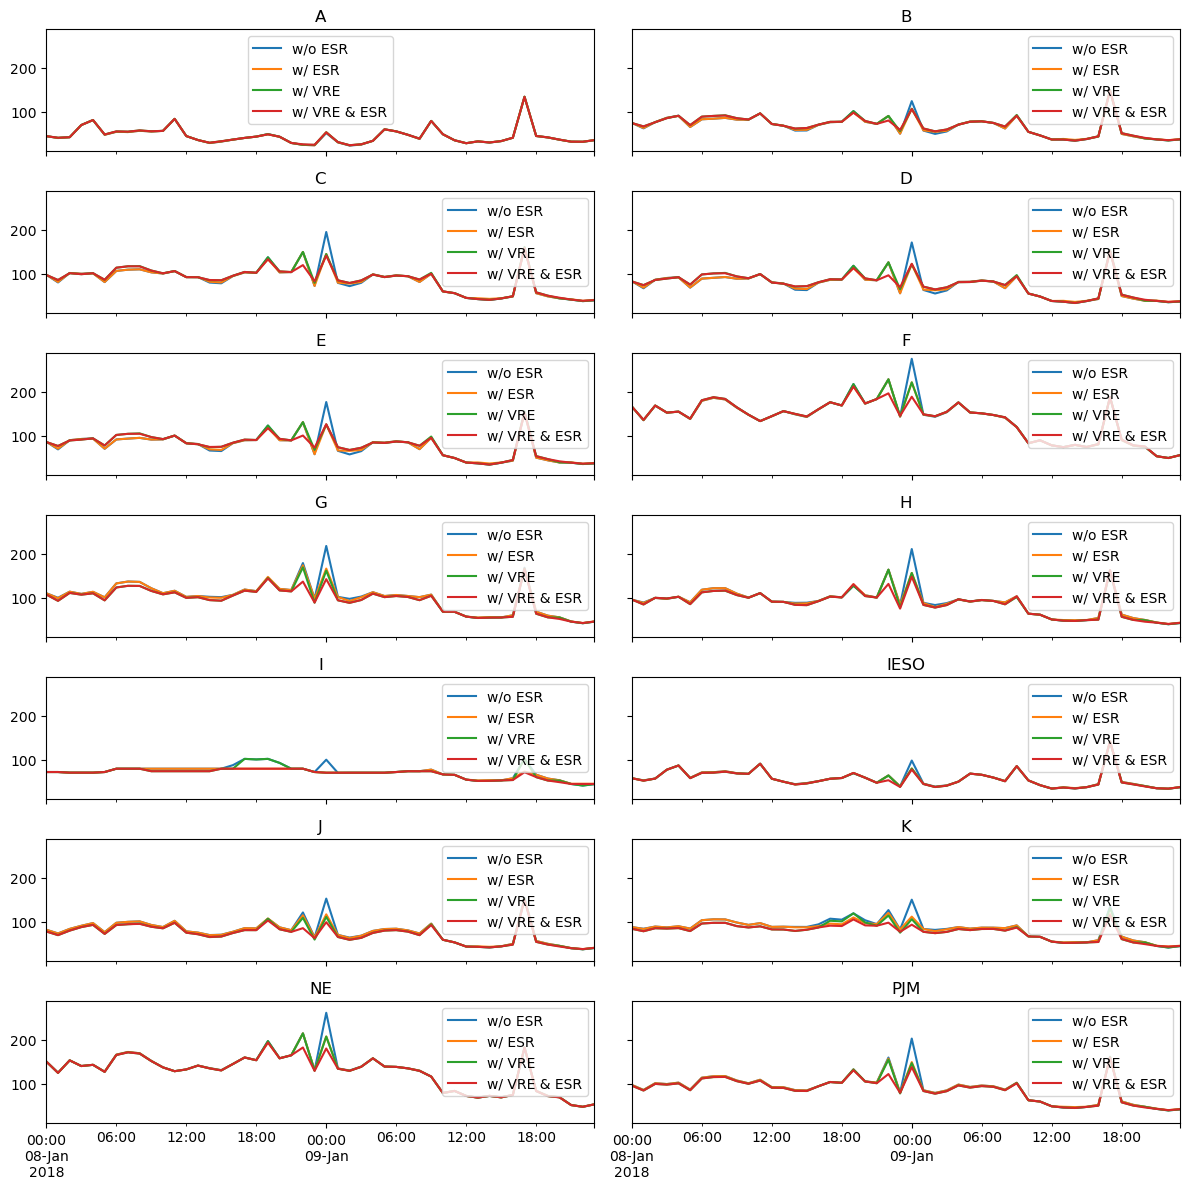

In [27]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    lmp_w_vre_zone.iloc[:, i].plot(ax=ax, label='w/ VRE')
    lmp_w_vre_esr_zone.iloc[:, i].plot(ax=ax, label='w/ VRE & ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()
    
fig.tight_layout()

<AxesSubplot:title={'center':'Zonal Load'}, xlabel='TimeStamp'>

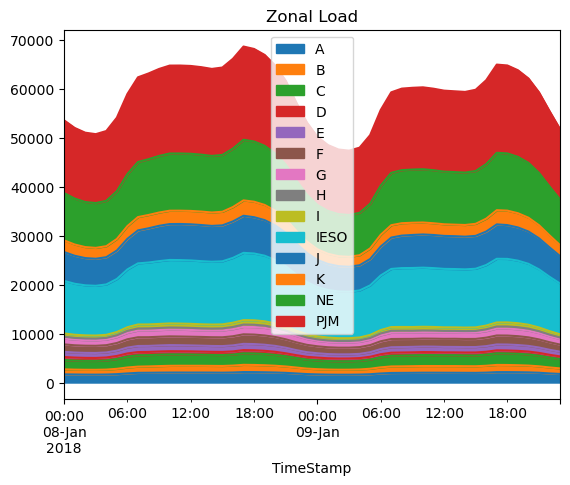

In [28]:
load_profile.columns = bus_names
load_profile_zone = load_profile.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

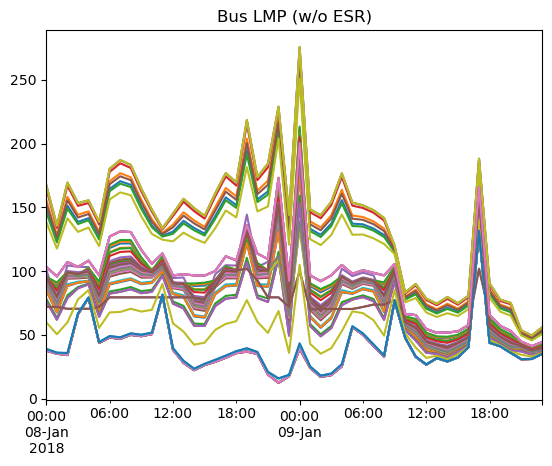

In [29]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

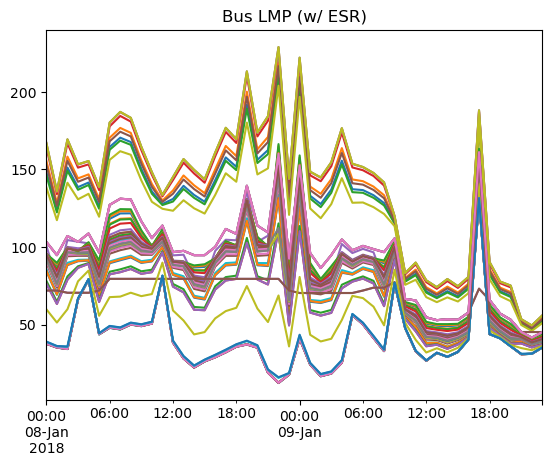

In [30]:
results_0_w_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

In [31]:
gen_max = genmax_profile[start_datetime:end_datetime]
gen_pg = results_0_wo_esr['PG'].iloc[:, :303]
gen_pg.columns = gen_max.columns
surplus = gen_max - gen_pg
surplus

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,-8.881784e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 01:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,-8.881784e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 02:00:00,17.1,18.5,18.5,0.0,0.1,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,3.552714e-15,0.0,0.0,8.881784e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 03:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,8.881784e-16,0.0,0.000000e+00,-3.552714e-15,0.000000e+00,0.0
2018-01-08 04:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,-3.552714e-15,-7.105427e-15,0.0
2018-01-08 05:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,8.881784e-16,0.0,0.000000e+00,0.000000e+00,7.105427e-15,0.0
2018-01-08 06:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,8.881784e-16,0.0,0.000000e+00,0.000000e+00,7.105427e-15,0.0
2018-01-08 07:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 08:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,-3.552714e-15,0.000000e+00,0.0


### With initial conditions

In [32]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-09 00:00:00
End time: 2018-01-10 23:00:00


#### Without ESR

In [33]:
# Create NYGrid object
nygrid_sim_1_wo_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 315
Number of branches: 94
Number of time periods: 48
Number of variables: 65520
Number of constraints: 80880
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp9025emwv.pyomo.lp
Reading time = 0.41 seconds
x1: 80880 rows, 65521 columns, 404442 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 80880 rows, 65521 columns and 404442 nonzeros
Model fingerprint: 0x66616d94
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 74890 rows and 50149

In [34]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 2526.2308466856502
s_if_max 8548.712625829545
s_if_min 609.591242063951
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [35]:
# Create NYGrid object
nygrid_sim_1_w_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=esr_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 345
Number of branches: 94
Number of time periods: 48
Number of variables: 74160
Number of constraints: 95310
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp2l5amvyk.pyomo.lp
Reading time = 0.55 seconds
x1: 95310 rows, 74161 columns, 434622 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 95310 rows, 74161 columns and 434622 nonzeros
Model fingerprint: 0xad8bfab9
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 87572 rows and 54243 

In [36]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 6061.205321457188
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE

In [37]:
# Create NYGrid object
nygrid_sim_1_w_vre = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            vre_prop=vre_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre.set_load_sch(load_profile)
nygrid_sim_1_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre.set_gen_init_data(gen_init=last_gen)

# Set options
# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre.solve_dc_opf()

# Get results
results_1_w_vre = nygrid_sim_1_w_vre.get_results_dc_opf()

Number of buses: 57
Number of generators: 406
Number of branches: 94
Number of time periods: 48
Number of variables: 78624
Number of constraints: 98352
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpcstlhy0w.pyomo.lp
Reading time = 0.49 seconds
x1: 98352 rows, 78625 columns, 447940 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 98352 rows, 78625 columns and 447940 nonzeros
Model fingerprint: 0x6ac7ce2f
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 92145 rows and 61673 

In [38]:
print("s_ramp_up", results_1_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre['s_load_shed'].sum())
print("s_if_max", results_1_w_vre['s_if_max'].sum())
print("s_if_min", results_1_w_vre['s_if_min'].sum())
print("s_br_max", results_1_w_vre['s_br_max'].sum())
print("s_br_min", results_1_w_vre['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 8627.772127384425
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE and ESR

In [39]:
# Create NYGrid object
nygrid_sim_1_w_vre_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=esr_prop,
                            vre_prop=vre_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre_esr.set_load_sch(load_profile)
nygrid_sim_1_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre_esr.solve_dc_opf()

# Get results
results_1_w_vre_esr = nygrid_sim_1_w_vre_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 436
Number of branches: 94
Number of time periods: 48
Number of variables: 87264
Number of constraints: 112782
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp_odb5eqm.pyomo.lp
Reading time = 0.53 seconds
x1: 112782 rows, 87265 columns, 478120 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 112782 rows, 87265 columns and 478120 nonzeros
Model fingerprint: 0x66a07af3
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 104624 rows and 65

In [40]:
print("s_ramp_up", results_1_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_1_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_1_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_1_w_vre_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 2063.8912533613584
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


## Process the results

In [41]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [42]:
# Format results
results_pg_0_wo_esr = results_0_wo_esr['PG']
thermal_pg_0_wo_esr = results_pg_0_wo_esr.iloc[:, :num_thermal]
thermal_pg_0_wo_esr = thermal_pg_0_wo_esr.rename(columns=gen_rename)
print(thermal_pg_0_wo_esr.head())

results_pg_0_w_esr = results_0_w_esr['PG']
thermal_pg_0_w_esr = results_pg_0_w_esr.iloc[:, :num_thermal]
thermal_pg_0_w_esr = thermal_pg_0_w_esr.rename(columns=gen_rename)
print(thermal_pg_0_w_esr.head())

results_pg_1_wo_esr = results_1_wo_esr['PG']
thermal_pg_1_wo_esr = results_pg_1_wo_esr.iloc[:, :num_thermal]
thermal_pg_1_wo_esr = thermal_pg_1_wo_esr.rename(columns=gen_rename)
print(thermal_pg_1_wo_esr.head())

results_pg_1_w_esr = results_1_w_esr['PG']
thermal_pg_1_w_esr = results_pg_1_w_esr.iloc[:, :num_thermal]
thermal_pg_1_w_esr = thermal_pg_1_w_esr.rename(columns=gen_rename)
print(thermal_pg_1_w_esr.head())

                     59 St.  GT 1  74 St.  GT 1  74 St.  GT 2  Allegany  \
2018-01-08 00:00:00           0.0           0.0           0.0      66.0   
2018-01-08 01:00:00           0.0           0.0           0.0      66.0   
2018-01-08 02:00:00           0.0           0.0           0.0      66.0   
2018-01-08 03:00:00           0.0           0.0           0.0      66.0   
2018-01-08 04:00:00           0.0           0.0           0.0      66.0   

                     Allied Frozen Storage  Arthur Kill Cogen  \
2018-01-08 00:00:00                    0.1               11.1   
2018-01-08 01:00:00                    0.1               11.1   
2018-01-08 02:00:00                    0.0               11.1   
2018-01-08 03:00:00                    0.1               11.1   
2018-01-08 04:00:00                    0.1               11.1   

                     Arthur Kill GT 1  Arthur Kill ST 2  Arthur Kill ST 3  \
2018-01-08 00:00:00              20.0             349.0             539.0   
2018

In [43]:
def plot_gen(thermal_pg, genhist, genmax, genmin, idx, title=None, ax=None):

    ax.plot(thermal_pg.index, thermal_pg.iloc[:, idx], marker='*', label='OPF')
    ax.plot(thermal_pg.index, genhist[start_datetime:end_datetime].iloc[:,idx], marker='o', label='historical')
    ax.plot(thermal_pg.index, genmax[start_datetime:end_datetime].iloc[:,idx], linestyle='--', label='max')
    ax.plot(thermal_pg.index, genmin[start_datetime:end_datetime].iloc[:,idx], linestyle='--', label='min')
    ax.legend()
    ax.set_title(title)

    return ax

In [44]:
gen_profile[start_datetime:end_datetime]

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-09 00:00:00,0.0,0.0,0.0,11.000000,0.0,11.1,0.0,349.0,539.000000,1.0,...,2.106174,27.160868,1.404116,0.307150,6.318522,5.265435,4.036833,26.195539,54.233979,19.306595
2018-01-09 01:00:00,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,96.0,1.000000,1.0,...,2.166141,27.934192,1.444094,0.315896,6.498423,5.415352,4.151770,26.941377,55.778128,19.856292
2018-01-09 02:00:00,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,96.0,1.000000,1.0,...,2.056782,26.523922,1.371188,0.299947,6.170347,5.141956,3.942166,25.581230,52.962145,18.853838
2018-01-09 03:00:00,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,96.0,1.000000,1.0,...,1.959201,25.265528,1.306134,0.285717,5.877603,4.898002,3.755135,24.367560,50.449422,17.959341
2018-01-09 04:00:00,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,96.0,1.000000,1.0,...,1.934805,24.950929,1.289870,0.282159,5.804416,4.837014,3.708377,24.064143,49.821241,17.735717
2018-01-09 05:00:00,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,96.0,1.000000,1.0,...,1.898633,24.484455,1.265755,0.276884,5.695899,4.746583,3.639047,23.614248,48.889800,17.404136
2018-01-09 06:00:00,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,96.0,1.000000,1.0,...,1.875079,24.180705,1.250053,0.273449,5.625237,4.687697,3.593901,23.321293,48.283281,17.188223
2018-01-09 07:00:00,0.0,0.0,0.0,66.000000,0.1,0.0,0.0,349.0,130.944066,1.0,...,1.869190,24.104767,1.246127,0.272590,5.607571,4.672976,3.582615,23.248055,48.131651,17.134245
2018-01-09 08:00:00,0.0,0.0,0.0,25.133982,0.0,11.1,0.0,349.0,539.000000,1.0,...,1.917981,24.733964,1.278654,0.279706,5.753943,4.794953,3.676130,23.854890,49.388013,17.581493


NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object


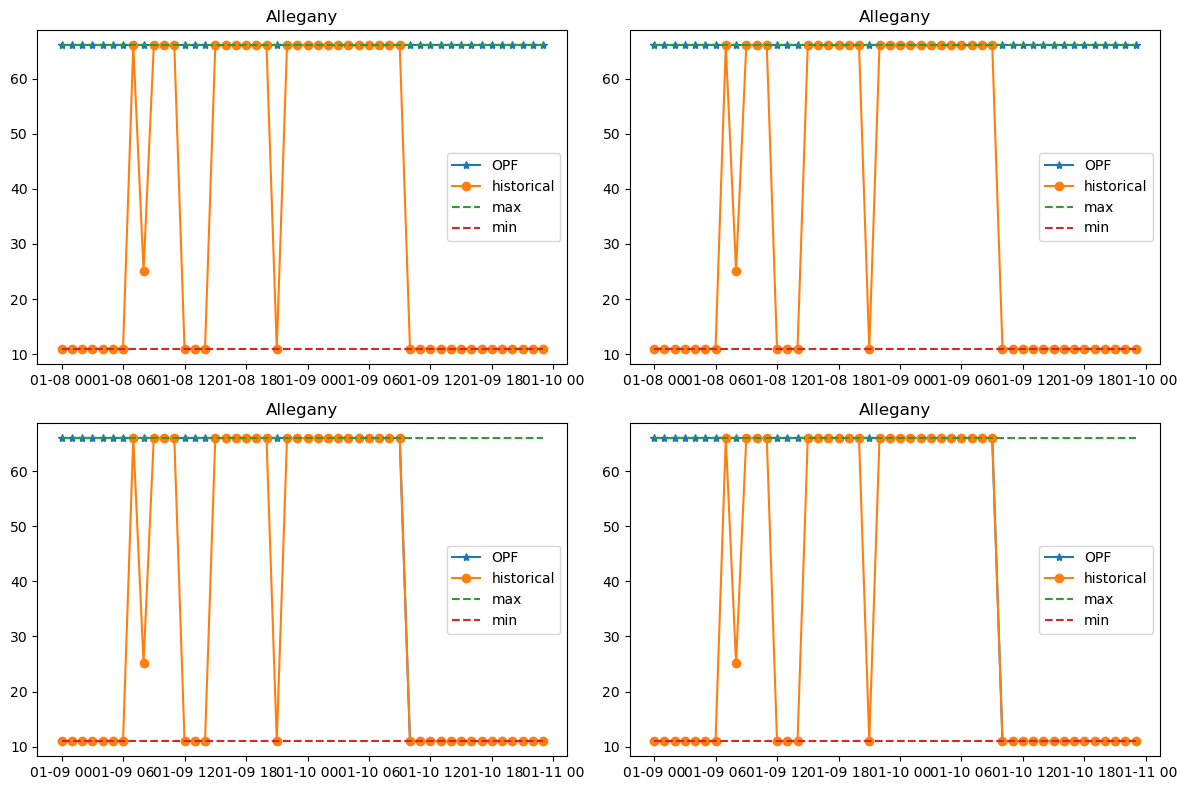

In [45]:
ii = 3
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object


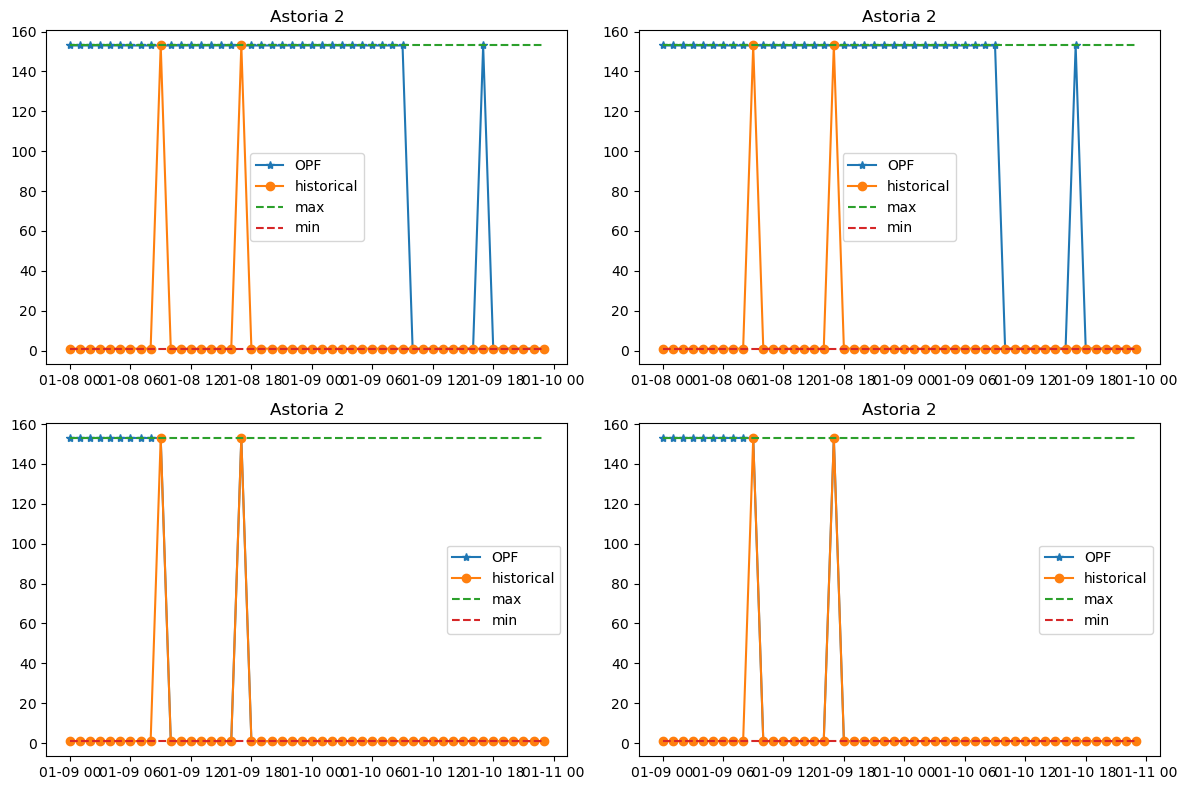

In [46]:
ii = 9
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()


NYISOName          East River 2
PTID                     323559
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7281
Longitude              -73.9742
maxPower                  227.0
minPower                   83.0
maxRampAgc                2.325
maxRamp10                 23.25
maxRamp30                 69.75
maxRamp60                 139.5
HeatRateLM_1           7.653993
HeatRateLM_0         446.985488
HeatRateLM_R2           0.98562
HeatRateQM_2           0.006054
HeatRateQM_1           5.870358
HeatRateQM_0          567.52178
HeatRateQM_R2          0.986302
useQM                         1
start-time                  12h
Name: 83, dtype: object


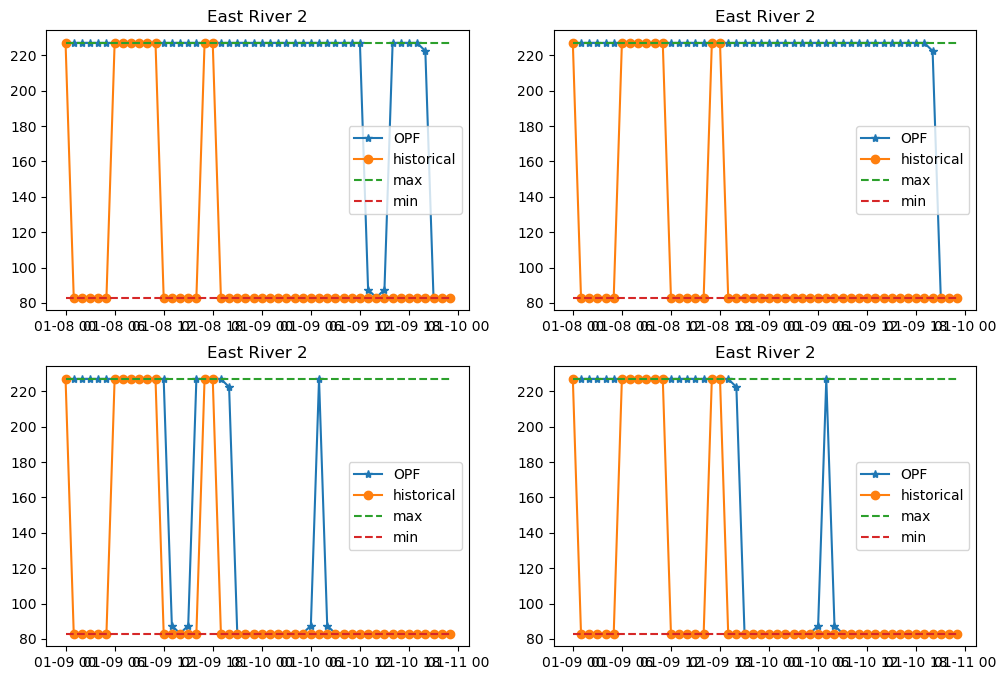

In [47]:
ii = 83
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
plt.show()